<a href="https://colab.research.google.com/github/Bripereira/DATA-SCIENCE-III/blob/main/Taller_1_Fake_News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import nltk
import spacy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# Descargar recursos necesarios de nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [3]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 60.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
# Cargar modelo de spaCy en inglés
nlp = spacy.load("en_core_web_sm")

In [5]:
# Cargar dataset
df = pd.read_csv('https://raw.githubusercontent.com/nacho1907/Bases/refs/heads/main/fake_or_real_news.csv')
df = df.rename(columns={"text": "texto", "label": "sentimiento"})

print(df.columns)
df.shape

Index(['Unnamed: 0', 'title', 'texto', 'sentimiento'], dtype='object')


(6335, 4)

In [6]:
# Contar cuantas noticias reales (1) y fakes(0) hay en el dataset

df=df.drop(columns=['Unnamed: 0'])
df["sentimiento"] = df["sentimiento"].map({"FAKE": 0, "REAL": 1})
print(df["sentimiento"].value_counts())


df.head(2)

sentimiento
1    3171
0    3164
Name: count, dtype: int64


,title,texto,sentimiento
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0


In [7]:
#Reducir la muestra a 1500

df2=df.sample(n=1500, random_state=42)
df2.head(2)

print(df2["sentimiento"].value_counts())

sentimiento
1    755
0    745
Name: count, dtype: int64


In [8]:
#DATA SET BALANCEADO

from imblearn.under_sampling import RandomUnderSampler

# Asegurémonos de que `df2` tiene las columnas 'texto' y 'sentimiento'
# Si no tienes `df2` todavía, reemplaza con `df_sampled` en su lugar.
X = df2["texto"]
y = df2["sentimiento"]

# Usamos RandomUnderSampler para balancear las clases
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X.values.reshape(-1, 1), y)

# Crear el DataFrame balanceado
df2_balanced = pd.DataFrame({
    "texto": X_resampled.flatten(),  # Convertir el array de vuelta en una serie de texto
    "sentimiento": y_resampled
})

# Verificar el balance
print(df2_balanced["sentimiento"].value_counts())

# Mostrar primeras filas del nuevo dataset balanceado
df2_balanced.head(2)

sentimiento
0    745
1    745
Name: count, dtype: int64


,texto,sentimiento
0,Will Trump pull a Brexit times ten? What would...,0
1,Clintons Are Under Multiple FBI Investigations...,0


In [9]:
def preprocess_text_spacy(text):
    # Convertir a minúsculas
    text = text.lower()

    # Eliminar caracteres especiales y números usando expresión regular
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Procesar con spaCy
    doc = nlp(text)

    # Eliminar stopwords y lematizar
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]

    # Unir las palabras de vuelta a una cadena
    return ' '.join(tokens)

# Aplicar la función de preprocesamiento a cada texto en el dataset
df2_balanced['texto'] = df2_balanced['texto'].apply(preprocess_text_spacy)

# Mostrar las primeras filas del dataset procesado
df2_balanced.head()

,texto,sentimiento
0,trump pull brexit time wikileak bring clinton ...,0
1,clinton multiple fbi investigation agent stymi...,0
2,dispatch eric zuesse piece crossposte strategi...,0
3,print \n ed facade crack somebody ask questi...,0
4,nanny jail force feed baby death share ike m...,0


In [10]:
#preparar el input para la nube de palabras
all_text = ' '.join(df2_balanced['texto'])

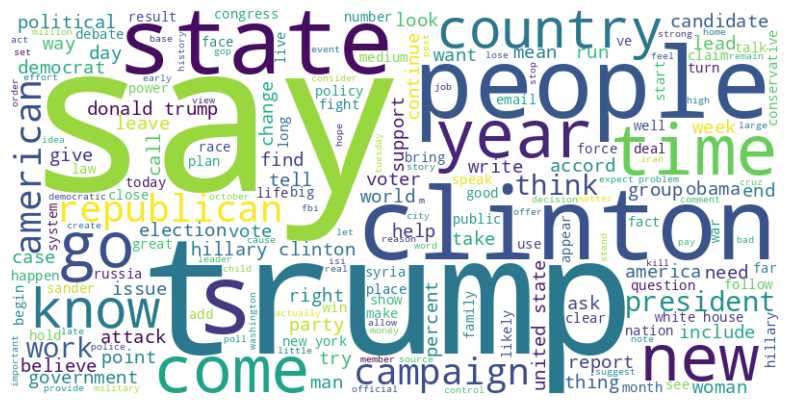

In [11]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Eliminar los ejes
plt.show()

Unigramas más comunes:
    N-gram  Frecuencia
0      say        6497
1    trump        5134
2  clinton        4517
3      not        3648
4    state        3040


<ipython-input-12-2d58e5793bd9>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')


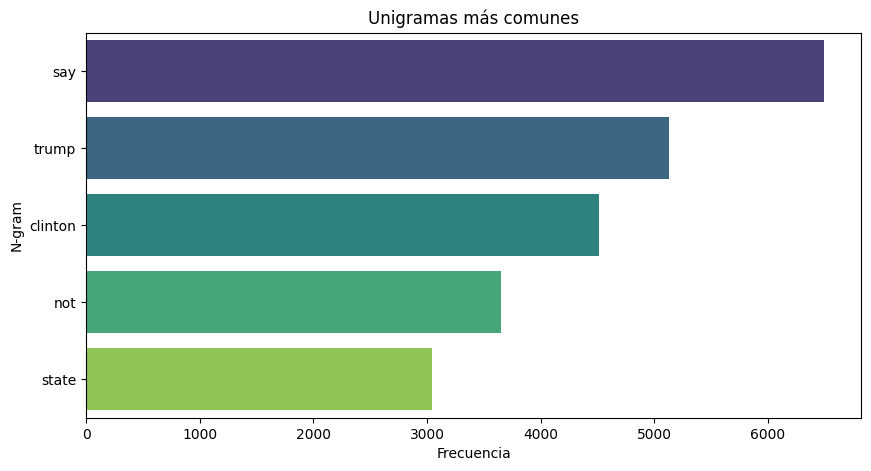


Bigramas más comunes:
            N-gram  Frecuencia
0  hillary clinton        1069
1     donald trump         855
2    united states         773
3      white house         604
4         new york         542


<ipython-input-12-2d58e5793bd9>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')


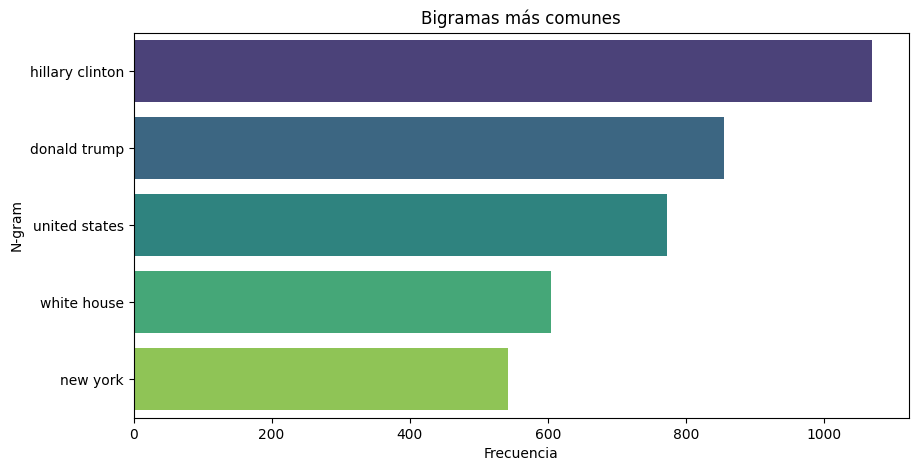


Trigramas más comunes:
                    N-gram  Frecuencia
0           new york times         134
1   president barack obama          75
2  president united states          72
3            new york city          62
4             sen ted cruz          58


<ipython-input-12-2d58e5793bd9>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')


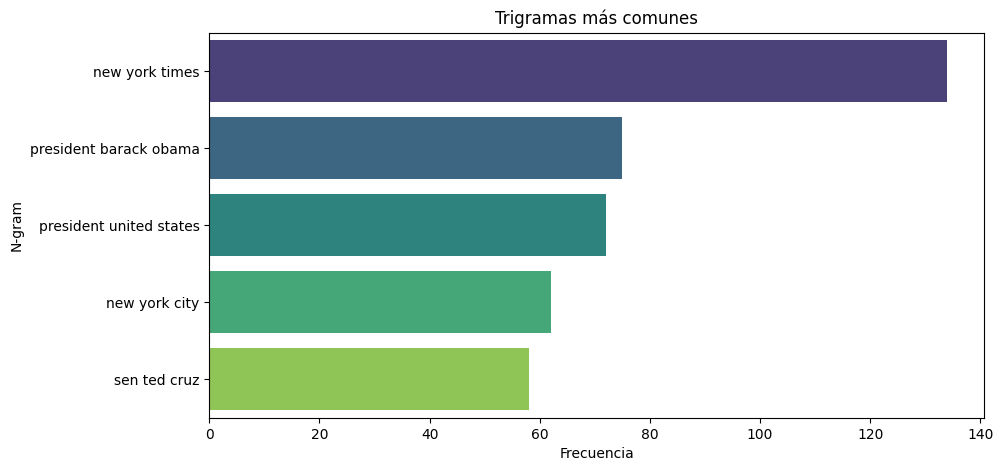

In [12]:
# Análisis de n-grams, adicionar bigramas, trigramas y cuatrigramas. Plotearlos.
def get_top_ngrams(corpus, n, top_k=5):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    X = vectorizer.fit_transform(corpus)
    ngram_counts = X.sum(axis=0).A1
    ngram_features = vectorizer.get_feature_names_out()
    ngram_freq = list(zip(ngram_features, ngram_counts))
    ngram_freq = sorted(ngram_freq, key=lambda x: x[1], reverse=True)[:top_k]
    return pd.DataFrame(ngram_freq, columns=['N-gram', 'Frecuencia'])

def plot_ngrams(ngram_df, title):
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')
    plt.title(title)
    plt.xlabel("Frecuencia")
    plt.ylabel("N-gram")
    plt.show()

# Obtener los unigrams, bigrams y trigrams de 'texto' en df2_balanced
unigrams = get_top_ngrams(df2_balanced['texto'], 1)
bigrams = get_top_ngrams(df2_balanced['texto'], 2)
trigrams = get_top_ngrams(df2_balanced['texto'], 3)

# Mostrar los resultados y graficarlos
print("Unigramas más comunes:")
print(unigrams)
plot_ngrams(unigrams, "Unigramas más comunes")

print("\nBigramas más comunes:")
print(bigrams)
plot_ngrams(bigrams, "Bigramas más comunes")

print("\nTrigramas más comunes:")
print(trigrams)
plot_ngrams(trigrams, "Trigramas más comunes")

In [13]:
# Empiezar con la practicar

In [14]:
# Separar los datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(df2_balanced['texto'], df2_balanced['sentimiento'], test_size=0.2, random_state=42)

In [15]:
# Mostrar el tamaño de los conjuntos
print(f"Tamaño del conjunto de entrenamiento: {len(X_train)}")
print(f"Tamaño del conjunto de prueba: {len(X_test)}")

Tamaño del conjunto de entrenamiento: 1192
Tamaño del conjunto de prueba: 298


In [22]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),  # Paso 1: Vectorización de texto con TF-IDF
    ('clf', MultinomialNB())       # Paso 2: Modelo de Naive Bayes Multinomial
])

In [23]:
#Aplicar el pipe

print("Entrenando el modelo...")  # Mensaje antes de entrenar
pipeline.fit(X_train, y_train)    # Entrenamiento del modelo
print("Finalizó el entrenamiento.")  # Mensaje después de entrenar

Entrenando el modelo...
Finalizó el entrenamiento.


In [24]:
y_pred = pipeline.predict(X_test)

# Evaluar la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)

print(f"Precisión del modelo: {accuracy:.4f}")

Precisión del modelo: 0.7919


In [25]:
# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7919463087248322
              precision    recall  f1-score   support

           0       0.97      0.59      0.73       143
           1       0.72      0.98      0.83       155

    accuracy                           0.79       298
   macro avg       0.84      0.78      0.78       298
weighted avg       0.84      0.79      0.78       298



In [26]:
##DataFlair - Initialize a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df =0.9)
## DataFlair - fit and transform train set, transform test set
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [27]:
from sklearn.linear_model import PassiveAggressiveClassifier
pac=PassiveAggressiveClassifier(max_iter=50)
pac.fit(tfidf_train,y_train)

PassiveAggressiveClassifier(max_iter=50)

In [29]:
y_pred2=pac.predict(tfidf_test)

# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred2))
print(classification_report(y_test, y_pred2))

Accuracy: 0.9362416107382551
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       143
           1       0.95      0.93      0.94       155

    accuracy                           0.94       298
   macro avg       0.94      0.94      0.94       298
weighted avg       0.94      0.94      0.94       298



## CONCLUSIONES

La prueba Naive Bayes muestra una mayor tendencia a clasificar una noticia como FALSA. Esto se evidencia en su alta precisión del 97% para detectar noticias falsas, pero con una precisión reducida del 72% en la detección de noticias VERDADERAS.

Por otro lado, el método Passive Aggressive Classifier, logró un desempeño más equilibrado, alcanzando una precisión superior al 90% en ambos tipos de noticias.